# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, imaging_type_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths), tissue type (labels), and imaging type columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_label_encoder:
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_label_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder and imaging type encoder
    le = train_dataset.get_label_encoder()
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [9]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [10]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [11]:
class SwinWithImagingType(nn.Module):
    def __init__(self, base_model, num_features, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(SwinWithImagingType, self).__init__()
        self.base_model = base_model
        
        # Remove the final head layer
        self.base_model.head = nn.Identity()
        
        # Imaging type embedding
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that takes both image features and imaging type
        self.classifier = nn.Linear(num_features + embedding_dim, num_classes)
        
    def forward(self, x, imaging_type):
        # Get image features
        image_features = self.base_model(x)
        
        # Get imaging type embedding
        imaging_embedding = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features
        combined_features = torch.cat([image_features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        return output

def create_swin_model(num_classes=4, num_imaging_types=2, pretrained=True, model_type='v2_b'):
    """
    Create Swin Transformer V2 model with imaging type input for multi-class classification
    
    Args:
        num_classes (int): Number of output classes
        num_imaging_types (int): Number of imaging types
        pretrained (bool): Whether to use pretrained weights
        model_type (str): Type of Swin model - 'v2_t', 'v2_s', 'v2_b'
    
    Returns:
        model: Swin Transformer model with imaging type support
    """
    if model_type.lower() == 'v2_t':
        base_model = models.swin_v2_t(pretrained=pretrained)
    elif model_type.lower() == 'v2_s':
        base_model = models.swin_v2_s(pretrained=pretrained)
    elif model_type.lower() == 'v2_b':
        base_model = models.swin_v2_b(pretrained=pretrained)
    else:
        raise ValueError(f"Invalid model_type: {model_type}. Choose 'v2_t', 'v2_s', or 'v2_b'")
    
    # Get num_features before modifying the model
    num_features = base_model.head.in_features
    
    # Wrap with imaging type support
    model = SwinWithImagingType(base_model, num_features=num_features, num_classes=num_classes, num_imaging_types=num_imaging_types)
    
    return model

# Configure GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [13]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [14]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train Swin V2 Tiny

Training Swin Transformer V2 Tiny with Imaging Type


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_V2_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_V2_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/swin_v2_t-b137f0e2.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_t-b137f0e2.pth


100%|██████████| 109M/109M [00:01<00:00, 75.6MB/s] 


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.72it/s, Loss=1.4477, Acc=0.2541]


Train Loss: 1.4477 Acc: 0.2541 Macro-F1: 0.2271


Val : 100%|██████████| 10/10 [00:01<00:00,  6.60it/s, Loss=1.3738, Acc=0.2895]


Val Loss: 1.3738 Acc: 0.2895 Macro-F1: 0.1768
✓ New best model saved with validation macro-F1: 0.1768

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  3.04it/s, Loss=1.3871, Acc=0.2327]


Train Loss: 1.3871 Acc: 0.2327 Macro-F1: 0.2314


Val : 100%|██████████| 10/10 [00:01<00:00,  7.01it/s, Loss=1.3307, Acc=0.4211]


Val Loss: 1.3307 Acc: 0.4211 Macro-F1: 0.3475
✓ New best model saved with validation macro-F1: 0.3475

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  3.05it/s, Loss=1.3982, Acc=0.2796]


Train Loss: 1.3982 Acc: 0.2796 Macro-F1: 0.2472


Val : 100%|██████████| 10/10 [00:01<00:00,  6.98it/s, Loss=1.3450, Acc=0.2993]


Val Loss: 1.3450 Acc: 0.2993 Macro-F1: 0.1923

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  3.05it/s, Loss=1.3899, Acc=0.2821]


Train Loss: 1.3899 Acc: 0.2821 Macro-F1: 0.2653


Val : 100%|██████████| 10/10 [00:01<00:00,  7.13it/s, Loss=1.3595, Acc=0.3487]


Val Loss: 1.3595 Acc: 0.3487 Macro-F1: 0.1730

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  3.05it/s, Loss=1.3795, Acc=0.2615]


Train Loss: 1.3795 Acc: 0.2615 Macro-F1: 0.2460


Val : 100%|██████████| 10/10 [00:01<00:00,  7.03it/s, Loss=1.3481, Acc=0.2500]


Val Loss: 1.3481 Acc: 0.2500 Macro-F1: 0.1595

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  3.05it/s, Loss=1.3739, Acc=0.2755]


Train Loss: 1.3739 Acc: 0.2755 Macro-F1: 0.2627


Val : 100%|██████████| 10/10 [00:01<00:00,  6.94it/s, Loss=1.3540, Acc=0.3257]


Val Loss: 1.3540 Acc: 0.3257 Macro-F1: 0.2338

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  3.05it/s, Loss=1.3773, Acc=0.3076]


Train Loss: 1.3773 Acc: 0.3076 Macro-F1: 0.2871


Val : 100%|██████████| 10/10 [00:01<00:00,  7.00it/s, Loss=1.3502, Acc=0.2895]


Val Loss: 1.3502 Acc: 0.2895 Macro-F1: 0.1777
Early stopping triggered after 7 epochs
Training complete in 1m 39s
Best validation macro-F1: 0.3475


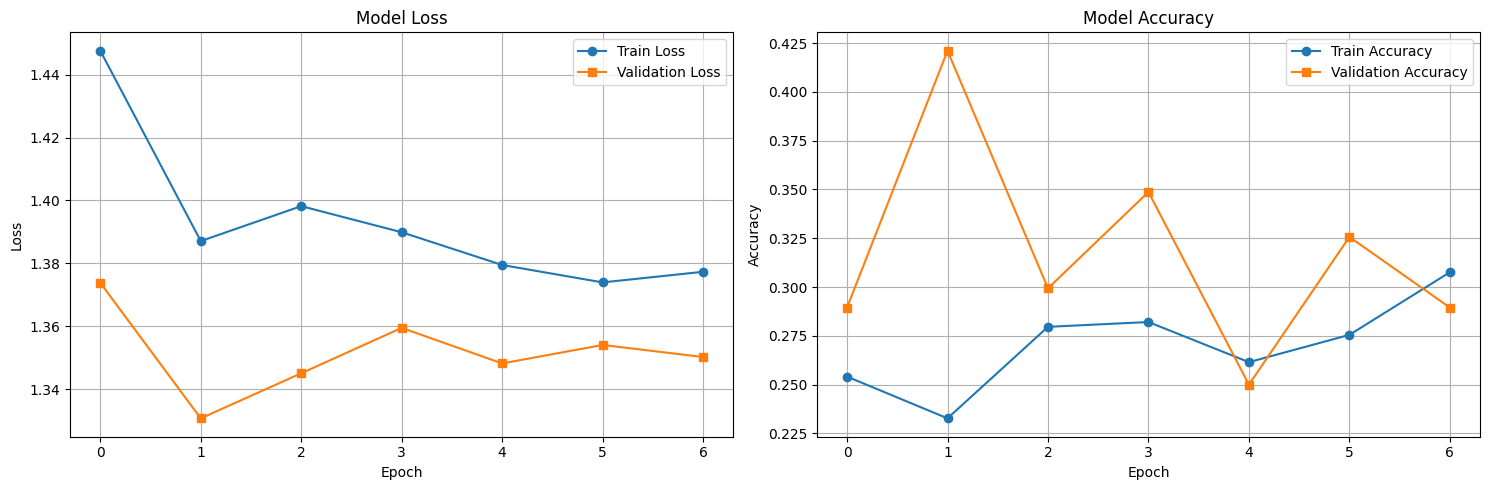

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


Test Accuracy: 42.86%
Test Loss: 1.3681

Classification Report:
              precision    recall  f1-score   support

         HGC       0.55      0.55      0.55        74
         LGC       1.00      0.08      0.14        53
         NST       0.47      0.97      0.63        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.43       189
   macro avg       0.50      0.40      0.33       189
weighted avg       0.59      0.43      0.38       189


Confusion Matrix:
[[41  0 21 12]
 [26  4  2 21]
 [ 1  0 36  0]
 [ 7  0 18  0]]

ROC-AUC Scores:
Macro-average AUC: 0.6674
Micro-average AUC: 0.6073
HGC AUC: 0.6344
LGC AUC: 0.6235
NST AUC: 0.9349
NTL AUC: 0.4766


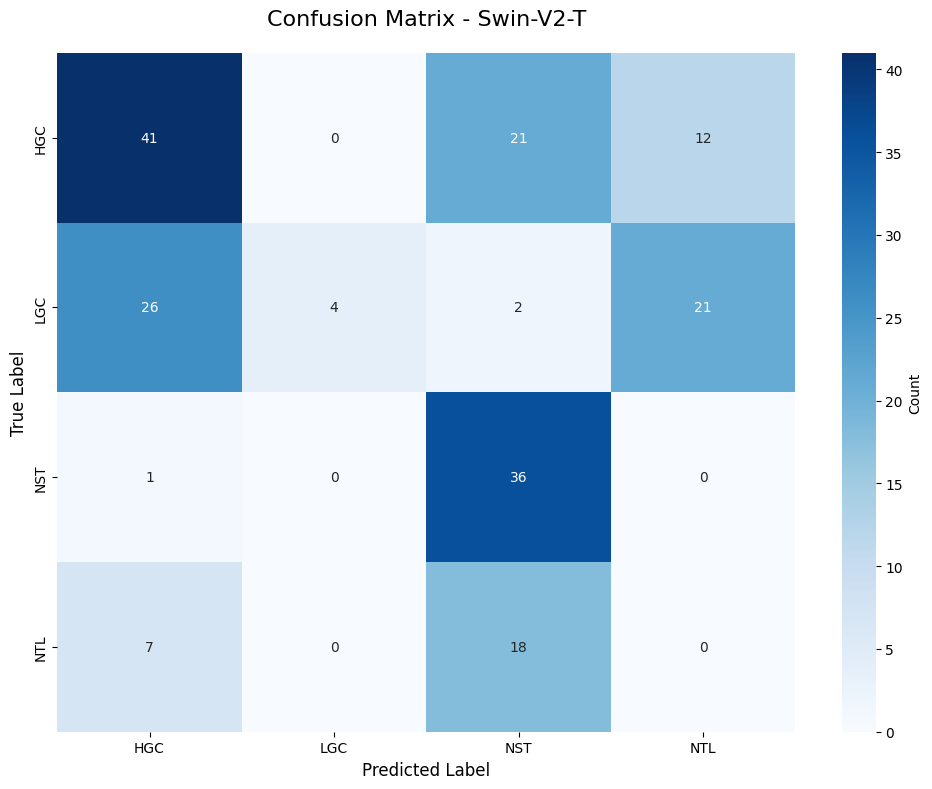

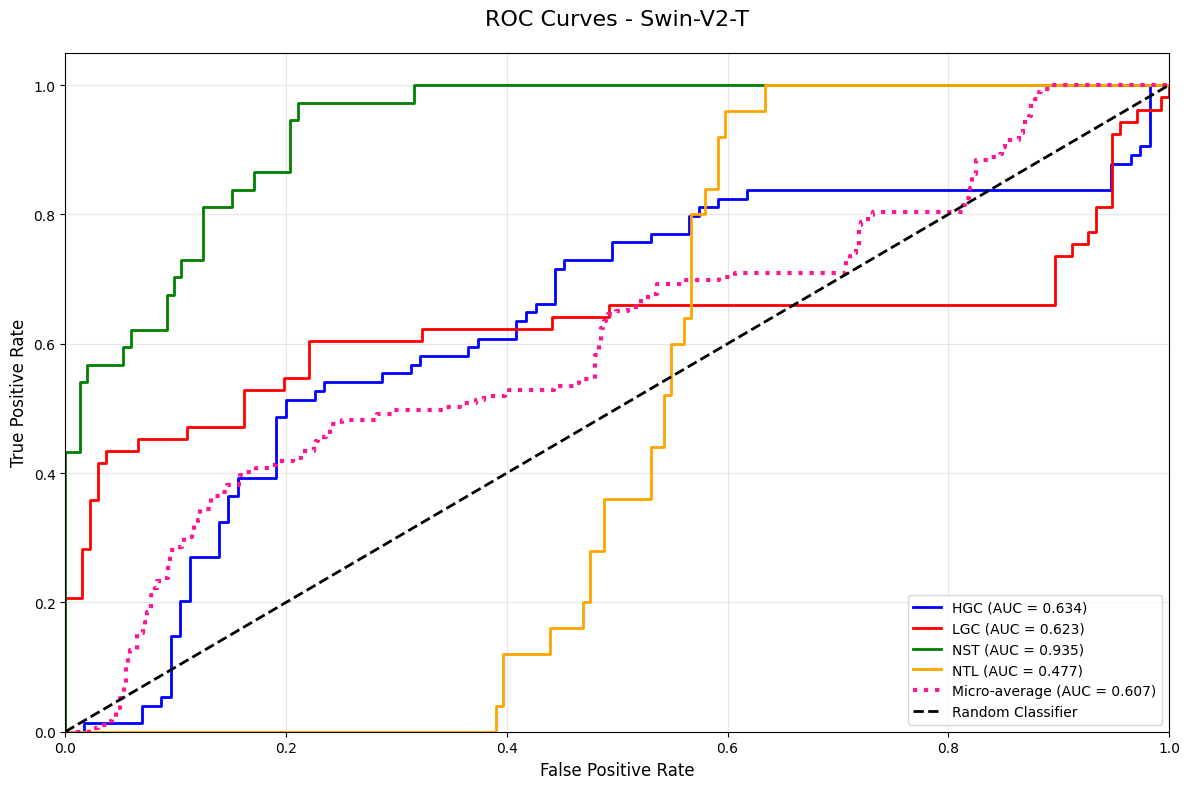


Swin-V2-T training and evaluation complete!


In [15]:
print("=" * 80)
print("Training Swin Transformer V2 Tiny with Imaging Type")
print("=" * 80)

# Create model
swin_v2_t = create_swin_model(num_classes=4, num_imaging_types=2, pretrained=True, model_type='v2_t')

# Create trainer
trainer_swin_v2_t = ModelTrainer(swin_v2_t, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_swin_v2_t = trainer_swin_v2_t.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="Swin-V2-T_with_ImagingType")

# Plot training history
trainer_swin_v2_t.plot_training_history(save_path='swin_v2_t_training_history.png')

# Evaluate model
results_swin_v2_t = trainer_swin_v2_t.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_swin_v2_t['confusion_matrix'], class_names, 'Swin-V2-T',
                      save_path='swin_v2_t_confusion_matrix.png')

# Plot ROC curves
roc_auc_swin_v2_t = plot_roc_curves(results_swin_v2_t['labels'], results_swin_v2_t['probabilities'], class_names, 'Swin-V2-T',
                                     save_path='swin_v2_t_roc_curves.png')

# Store results
results_swin_v2_t['model_name'] = 'Swin-V2-T'
results_swin_v2_t['roc_auc'] = roc_auc_swin_v2_t
all_results.append(results_swin_v2_t)

print("\nSwin-V2-T training and evaluation complete!")

## Train Swin V2 Small

Training Swin Transformer V2 Small with Imaging Type


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/swin_v2_s-637d8ceb.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_s-637d8ceb.pth


100%|██████████| 191M/191M [00:02<00:00, 78.0MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.78it/s, Loss=1.4574, Acc=0.2632]


Train Loss: 1.4574 Acc: 0.2632 Macro-F1: 0.2471


Val : 100%|██████████| 10/10 [00:02<00:00,  4.56it/s, Loss=1.3559, Acc=0.3684]


Val Loss: 1.3559 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.78it/s, Loss=1.4057, Acc=0.2944]


Train Loss: 1.4057 Acc: 0.2944 Macro-F1: 0.2478


Val : 100%|██████████| 10/10 [00:02<00:00,  4.57it/s, Loss=1.3614, Acc=0.3684]


Val Loss: 1.3614 Acc: 0.3684 Macro-F1: 0.1346

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.78it/s, Loss=1.4073, Acc=0.2459]


Train Loss: 1.4073 Acc: 0.2459 Macro-F1: 0.2322


Val : 100%|██████████| 10/10 [00:02<00:00,  4.57it/s, Loss=1.3835, Acc=0.3289]


Val Loss: 1.3835 Acc: 0.3289 Macro-F1: 0.1849
✓ New best model saved with validation macro-F1: 0.1849

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.78it/s, Loss=1.3880, Acc=0.2681]


Train Loss: 1.3880 Acc: 0.2681 Macro-F1: 0.2538


Val : 100%|██████████| 10/10 [00:02<00:00,  4.32it/s, Loss=1.3486, Acc=0.3684]


Val Loss: 1.3486 Acc: 0.3684 Macro-F1: 0.1346

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=1.3853, Acc=0.2944]


Train Loss: 1.3853 Acc: 0.2944 Macro-F1: 0.2672


Val : 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, Loss=1.3750, Acc=0.3289]


Val Loss: 1.3750 Acc: 0.3289 Macro-F1: 0.1849

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.78it/s, Loss=1.3875, Acc=0.2747]


Train Loss: 1.3875 Acc: 0.2747 Macro-F1: 0.2595


Val : 100%|██████████| 10/10 [00:02<00:00,  4.57it/s, Loss=1.3751, Acc=0.2895]


Val Loss: 1.3751 Acc: 0.2895 Macro-F1: 0.1768

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.78it/s, Loss=1.3820, Acc=0.2475]


Train Loss: 1.3820 Acc: 0.2475 Macro-F1: 0.2369


Val : 100%|██████████| 10/10 [00:02<00:00,  4.61it/s, Loss=1.3654, Acc=0.2895]


Val Loss: 1.3654 Acc: 0.2895 Macro-F1: 0.1768

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.78it/s, Loss=1.3748, Acc=0.2508]


Train Loss: 1.3748 Acc: 0.2508 Macro-F1: 0.2178


Val : 100%|██████████| 10/10 [00:02<00:00,  4.58it/s, Loss=1.3664, Acc=0.2895]


Val Loss: 1.3664 Acc: 0.2895 Macro-F1: 0.1768
Early stopping triggered after 8 epochs
Training complete in 3m 10s
Best validation macro-F1: 0.1849


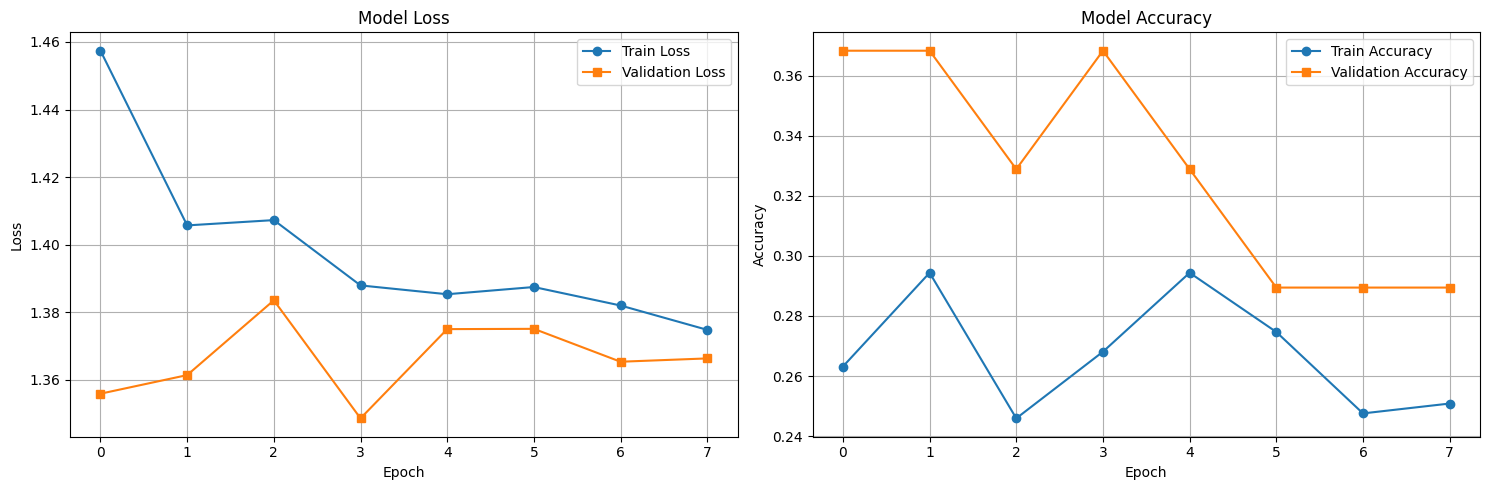

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.91it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 13.76%
Test Loss: 1.3922

Classification Report:
              precision    recall  f1-score   support

         HGC       0.00      0.00      0.00        74
         LGC       0.17      0.49      0.26        53
         NST       0.00      0.00      0.00        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.14       189
   macro avg       0.04      0.12      0.06       189
weighted avg       0.05      0.14      0.07       189


Confusion Matrix:
[[ 0 62  0 12]
 [ 0 26  0 27]
 [ 0 37  0  0]
 [ 0 25  0  0]]

ROC-AUC Scores:
Macro-average AUC: 0.3873
Micro-average AUC: 0.5184
HGC AUC: 0.3671
LGC AUC: 0.2528
NST AUC: 0.7255
NTL AUC: 0.2038


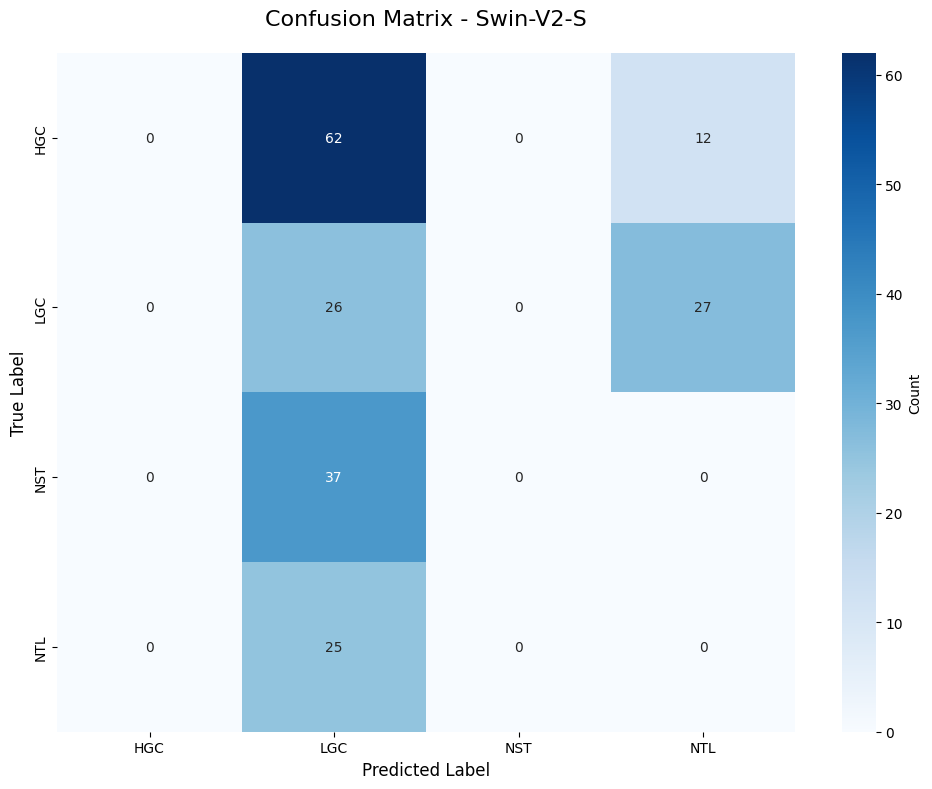

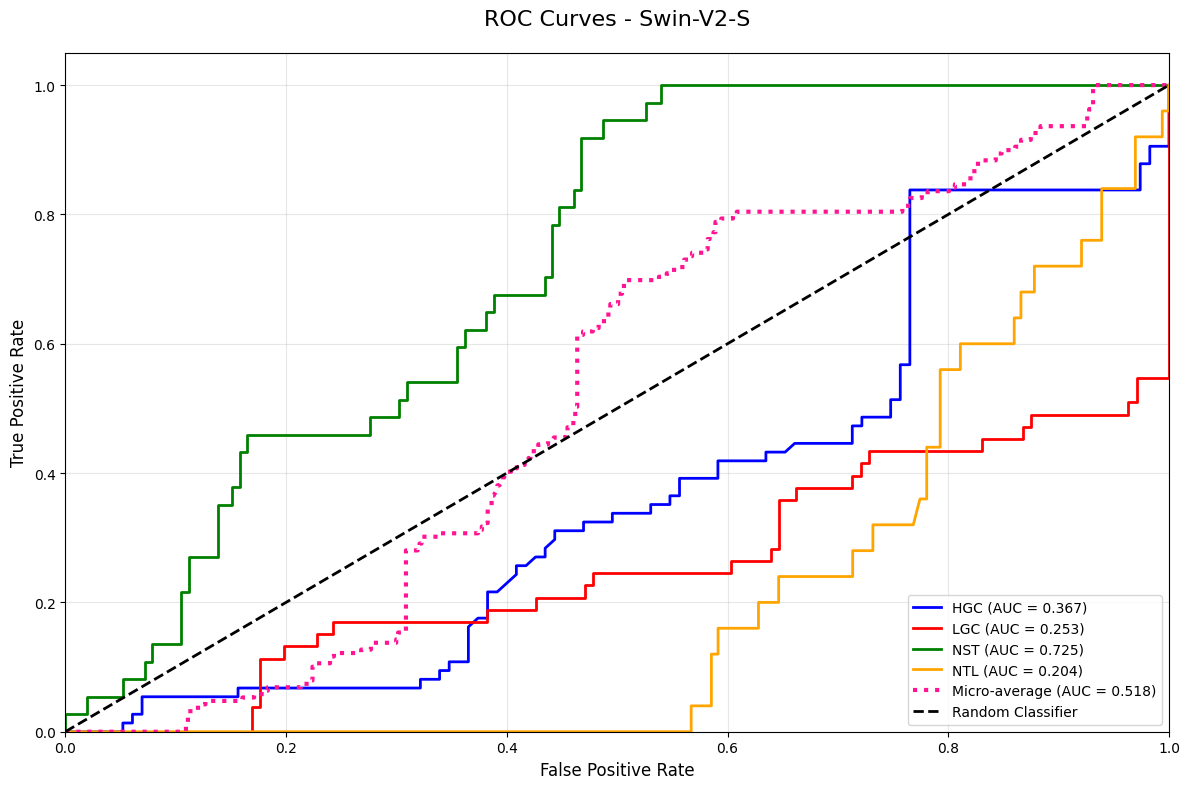


Swin-V2-S training and evaluation complete!


In [16]:
print("=" * 80)
print("Training Swin Transformer V2 Small with Imaging Type")
print("=" * 80)

# Create model
swin_v2_s = create_swin_model(num_classes=4, num_imaging_types=2, pretrained=True, model_type='v2_s')

# Create trainer
trainer_swin_v2_s = ModelTrainer(swin_v2_s, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_swin_v2_s = trainer_swin_v2_s.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="Swin-V2-S_with_ImagingType")

# Plot training history
trainer_swin_v2_s.plot_training_history(save_path='swin_v2_s_training_history.png')

# Evaluate model
results_swin_v2_s = trainer_swin_v2_s.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_swin_v2_s['confusion_matrix'], class_names, 'Swin-V2-S',
                      save_path='swin_v2_s_confusion_matrix.png')

# Plot ROC curves
roc_auc_swin_v2_s = plot_roc_curves(results_swin_v2_s['labels'], results_swin_v2_s['probabilities'], class_names, 'Swin-V2-S',
                                     save_path='swin_v2_s_roc_curves.png')

# Store results
results_swin_v2_s['model_name'] = 'Swin-V2-S'
results_swin_v2_s['roc_auc'] = roc_auc_swin_v2_s
all_results.append(results_swin_v2_s)

print("\nSwin-V2-S training and evaluation complete!")

## Train Swin V2 Base

Training Swin Transformer V2 Base with Imaging Type


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_V2_B_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_V2_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth


100%|██████████| 336M/336M [00:04<00:00, 86.1MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:31<00:00,  1.22it/s, Loss=1.4184, Acc=0.2566]


Train Loss: 1.4184 Acc: 0.2566 Macro-F1: 0.2418


Val : 100%|██████████| 10/10 [00:03<00:00,  3.30it/s, Loss=1.3337, Acc=0.3618]


Val Loss: 1.3337 Acc: 0.3618 Macro-F1: 0.2259
✓ New best model saved with validation macro-F1: 0.2259

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:31<00:00,  1.22it/s, Loss=1.4259, Acc=0.2656]


Train Loss: 1.4259 Acc: 0.2656 Macro-F1: 0.2445


Val : 100%|██████████| 10/10 [00:03<00:00,  3.28it/s, Loss=1.3836, Acc=0.2895]


Val Loss: 1.3836 Acc: 0.2895 Macro-F1: 0.1768

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:31<00:00,  1.22it/s, Loss=1.3875, Acc=0.2969]


Train Loss: 1.3875 Acc: 0.2969 Macro-F1: 0.2706


Val : 100%|██████████| 10/10 [00:03<00:00,  3.20it/s, Loss=1.4015, Acc=0.2928]


Val Loss: 1.4015 Acc: 0.2928 Macro-F1: 0.1830

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:31<00:00,  1.22it/s, Loss=1.4252, Acc=0.2434]


Train Loss: 1.4252 Acc: 0.2434 Macro-F1: 0.2312


Val : 100%|██████████| 10/10 [00:03<00:00,  3.30it/s, Loss=1.3757, Acc=0.2500]


Val Loss: 1.3757 Acc: 0.2500 Macro-F1: 0.1595

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:31<00:00,  1.22it/s, Loss=1.3845, Acc=0.2730]


Train Loss: 1.3845 Acc: 0.2730 Macro-F1: 0.2591


Val : 100%|██████████| 10/10 [00:03<00:00,  3.30it/s, Loss=1.3865, Acc=0.3289]


Val Loss: 1.3865 Acc: 0.3289 Macro-F1: 0.1849

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:31<00:00,  1.22it/s, Loss=1.3833, Acc=0.2582]


Train Loss: 1.3833 Acc: 0.2582 Macro-F1: 0.2424


Val : 100%|██████████| 10/10 [00:03<00:00,  3.32it/s, Loss=1.3598, Acc=0.2895]


Val Loss: 1.3598 Acc: 0.2895 Macro-F1: 0.1768
Early stopping triggered after 6 epochs
Training complete in 3m 26s
Best validation macro-F1: 0.2259


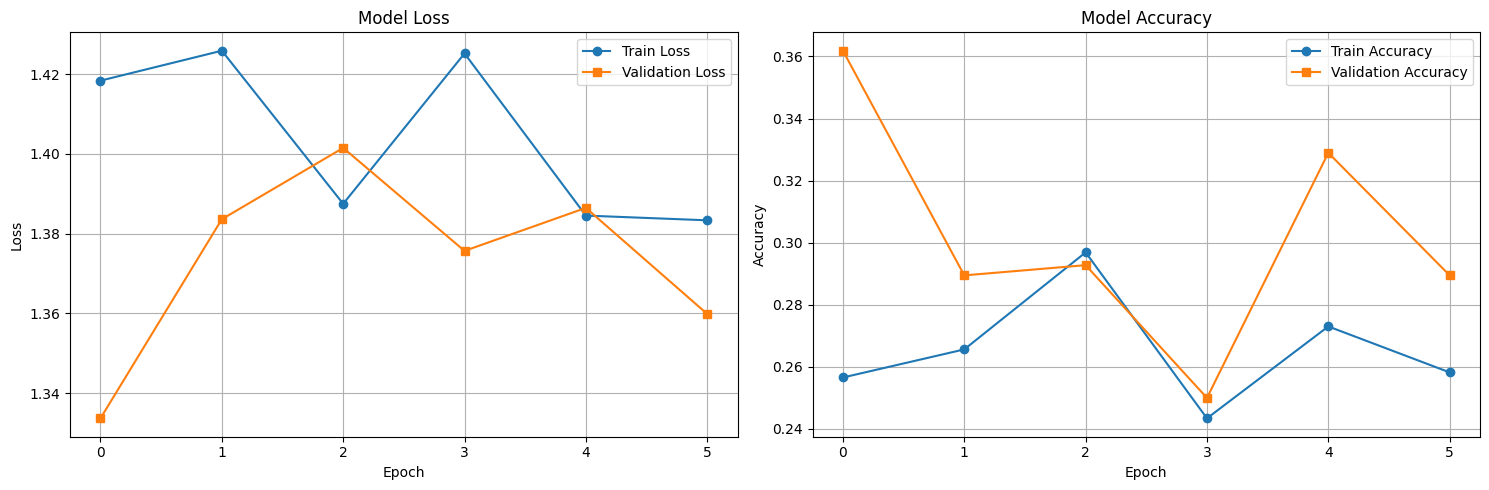

Evaluating on test set...


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 40.21%
Test Loss: 1.3414

Classification Report:
              precision    recall  f1-score   support

         HGC       0.38      0.80      0.51        74
         LGC       0.00      0.00      0.00        53
         NST       0.52      0.46      0.49        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.40       189
   macro avg       0.22      0.31      0.25       189
weighted avg       0.25      0.40      0.30       189


Confusion Matrix:
[[59  0 15  0]
 [53  0  0  0]
 [20  0 17  0]
 [24  0  1  0]]

ROC-AUC Scores:
Macro-average AUC: 0.6999
Micro-average AUC: 0.6689
HGC AUC: 0.5149
LGC AUC: 0.9299
NST AUC: 0.8519
NTL AUC: 0.5029


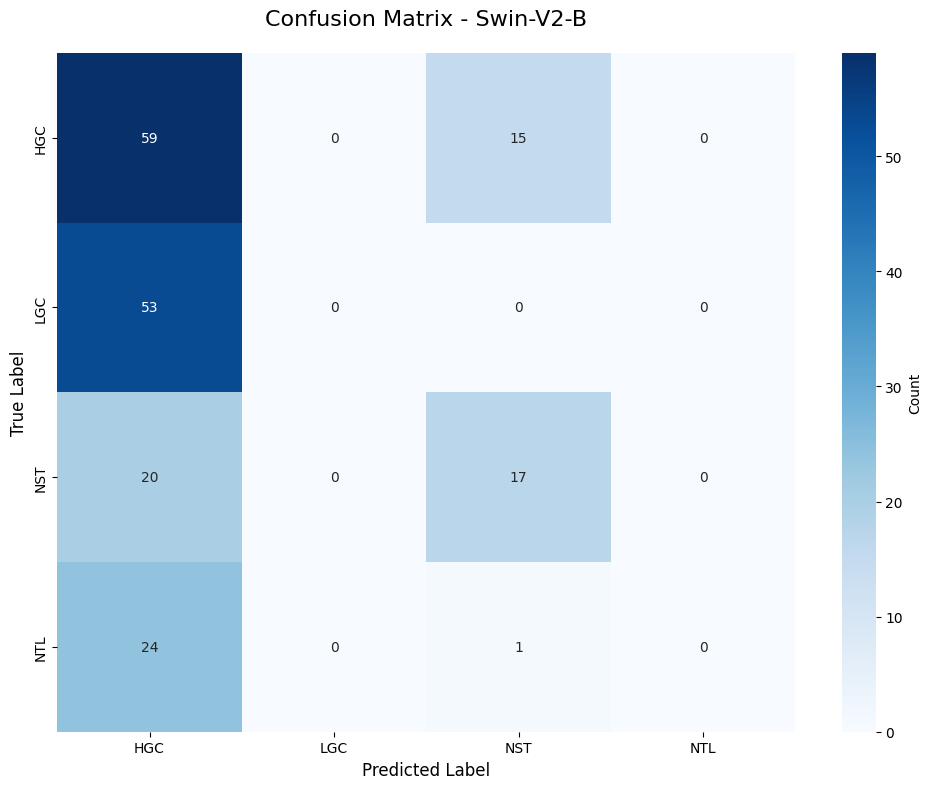

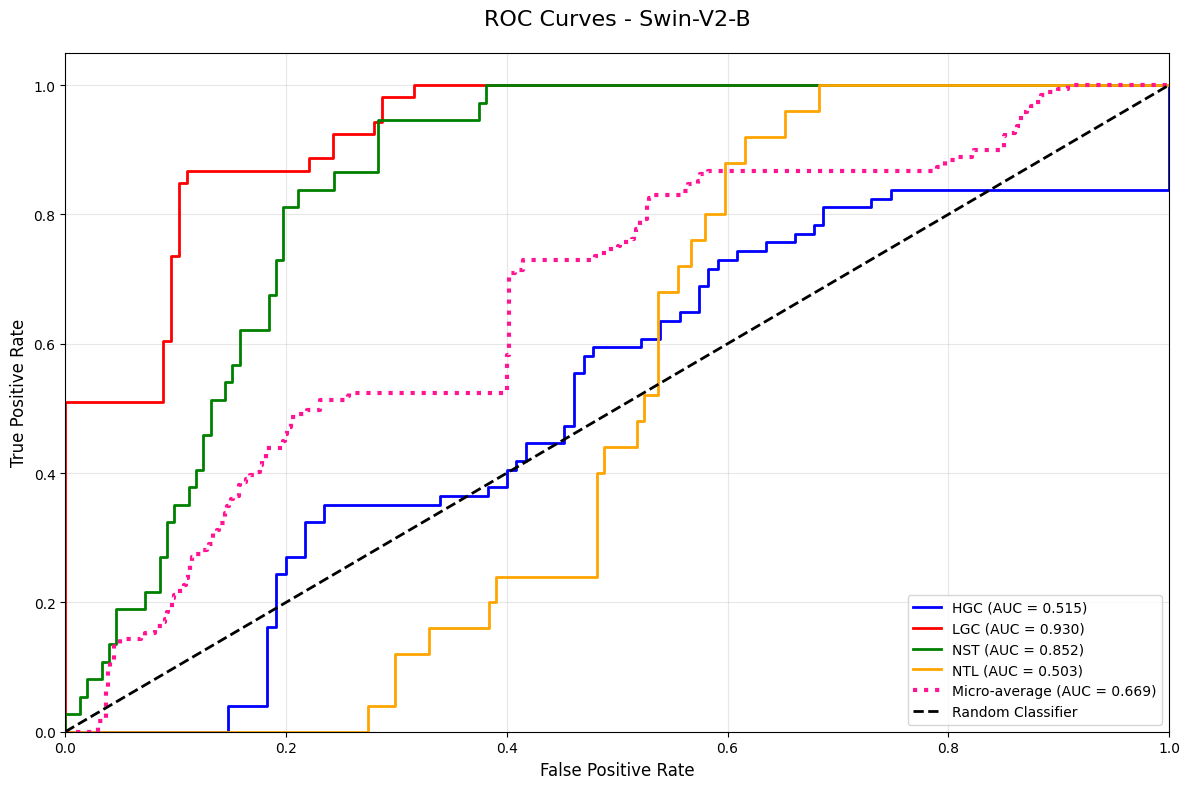


Swin-V2-B training and evaluation complete!


In [17]:
print("=" * 80)
print("Training Swin Transformer V2 Base with Imaging Type")
print("=" * 80)

# Create model
swin_v2_b = create_swin_model(num_classes=4, num_imaging_types=2, pretrained=True, model_type='v2_b')

# Create trainer
trainer_swin_v2_b = ModelTrainer(swin_v2_b, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_swin_v2_b = trainer_swin_v2_b.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="Swin-V2-B_with_ImagingType")

# Plot training history
trainer_swin_v2_b.plot_training_history(save_path='swin_v2_b_training_history.png')

# Evaluate model
results_swin_v2_b = trainer_swin_v2_b.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_swin_v2_b['confusion_matrix'], class_names, 'Swin-V2-B',
                      save_path='swin_v2_b_confusion_matrix.png')

# Plot ROC curves
roc_auc_swin_v2_b = plot_roc_curves(results_swin_v2_b['labels'], results_swin_v2_b['probabilities'], class_names, 'Swin-V2-B',
                                     save_path='swin_v2_b_roc_curves.png')

# Store results
results_swin_v2_b['model_name'] = 'Swin-V2-B'
results_swin_v2_b['roc_auc'] = roc_auc_swin_v2_b
all_results.append(results_swin_v2_b)

print("\nSwin-V2-B training and evaluation complete!")

# Save All Metrics to CSV

In [18]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'Swin_V2_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: Swin_V2_metrics.csv

Metrics Summary:
       Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall  NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  Swin-V2-T         42.857143      1.368074             0.503550          0.400625      0.330566                0.585990             0.428571         0.378475       0.546667    0.554054  0.550336         74.0       1.000000    0.075472  0.140351         53.0       0.467532    0.972973  0.631579         37.0            0.0         0.0     0.0         25.0   0.667353   0.607271  0.634430  0.623474  0.934922  0.476585      0.634430      0.623474